In [1]:
!nvidia-smi


Thu Mar 13 12:22:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:
!pip install tensorflow


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import random
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

In [5]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Yp3RK5raZJ7EW8cRulik")
project = rf.workspace("icvnz").project("chest-zhijh")
version = project.version(1)
dataset = version.download("folder")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 10.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to chest-1 in folder:: 100%|██████████| 5020/5020 [00:01<00:00, 2655.68it/s]


In [6]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Yp3RK5raZJ7EW8cRulik")
project = rf.workspace("eheh").project("lung-disease-classification-xy6bz")
version = project.version(2)
dataset = version.download("folder")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Lung-Disease-Classification-2 in folder:: 100%|██████████| 19132/19132 [00:03<00:00, 5789.03it/s]


In [7]:
source_base = "/content/Lung-Disease-Classification-2"
destination_base = "/content/chest-1"

subfolders = ["train", "test", "valid"]

disease_folders = ["Fibrosis","Edema"]

for subfolder in subfolders:
    for disease in disease_folders:
        src_path = os.path.join(source_base, subfolder, disease)
        dest_path = os.path.join(destination_base, subfolder, disease)

        if os.path.exists(src_path):
            shutil.move(src_path, dest_path)
            print(f"Moved {src_path} → {dest_path}")
        else:
            print(f"Skipping {src_path}, does not exist.")


Moved /content/Lung-Disease-Classification-2/train/Fibrosis → /content/chest-1/train/Fibrosis
Moved /content/Lung-Disease-Classification-2/train/Edema → /content/chest-1/train/Edema
Moved /content/Lung-Disease-Classification-2/test/Fibrosis → /content/chest-1/test/Fibrosis
Moved /content/Lung-Disease-Classification-2/test/Edema → /content/chest-1/test/Edema
Moved /content/Lung-Disease-Classification-2/valid/Fibrosis → /content/chest-1/valid/Fibrosis
Moved /content/Lung-Disease-Classification-2/valid/Edema → /content/chest-1/valid/Edema


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

input_shape = (256,256,3)

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    horizontal_flip =True,
    vertical_flip = True ,
    fill_mode ='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)

train_generator = train_datagen.flow_from_directory(
    '/content/chest-1/train',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    subset='training',
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/chest-1/valid',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
)


test_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)

test_generator = test_datagen.flow_from_directory(
    '/content/chest-1/test',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 8603 images belonging to 5 classes.
Found 1546 images belonging to 5 classes.
Found 763 images belonging to 5 classes.


In [9]:
class_indices = train_generator.class_indices
labels = {value: key for key, value in class_indices.items()}

<Figure size 1500x400 with 0 Axes>

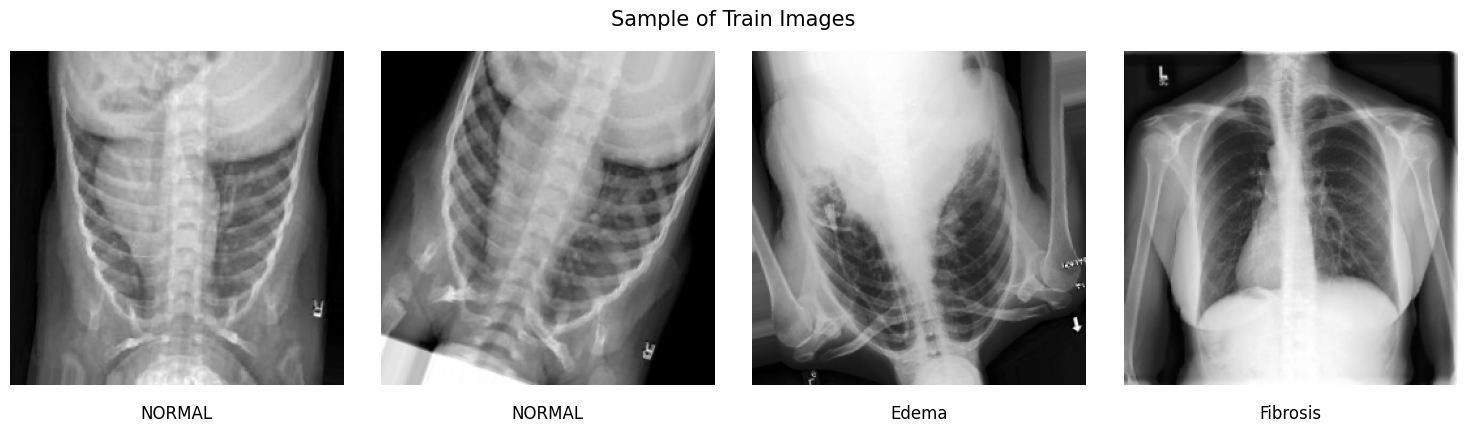

<Figure size 1500x400 with 0 Axes>

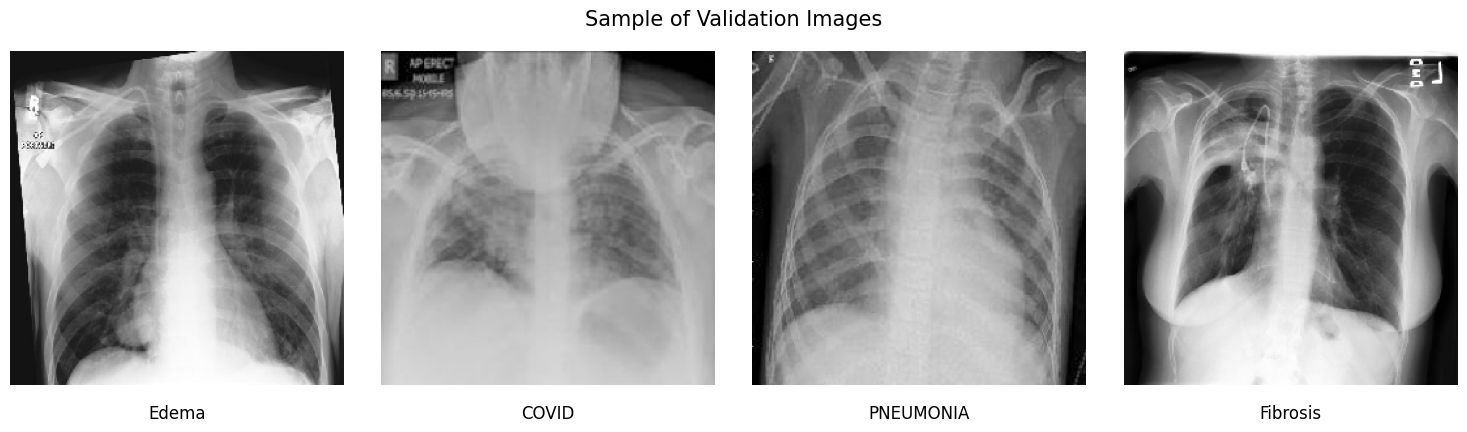

In [10]:
def showthem(subset='train'):
    plt.figure(figsize=(15, 4))
    gen = train_generator if subset == 'train' else validation_generator
    title = 'Sample of Train Images' if subset == 'train' else 'Sample of Validation Images'

    img_batch, label_batch = next(gen)

    fig, axes = plt.subplots(1, 4, figsize=(15, 4))

    for i in range(4):
        ax = axes[i]
        ax.imshow(img_batch[i])

        ax.text(0.5, -0.1, f"{labels[np.argmax(label_batch[i])]}", transform=ax.transAxes, fontsize=12, ha='center')
        ax.axis('off')

    plt.suptitle(title, size=15)
    plt.tight_layout()
    plt.show()

showthem()
showthem("validation")


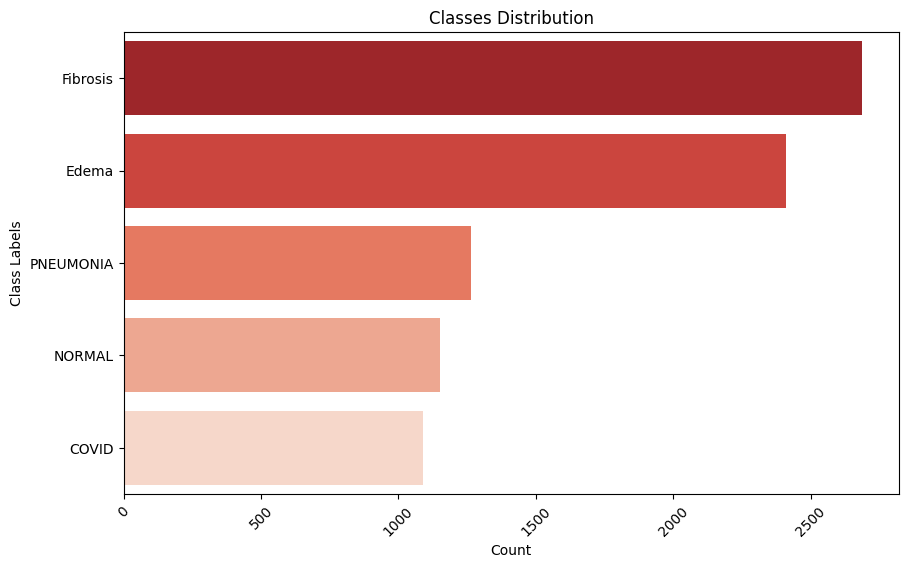

In [11]:
class_counts = train_generator.classes
class_labels = list(train_generator.class_indices.keys())
counts=[class_counts.tolist().count(i) for i in range(len(class_labels))]

dd = pd.DataFrame({'labels': class_labels, 'counts': counts})
dd = dd.sort_values(by='counts', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='counts', y='labels', data=dd, palette='Reds_r')
plt.xlabel('Count')
plt.ylabel('Class Labels')
plt.title('Classes Distribution')
plt.xticks(rotation=45)
plt.show()

In [28]:
from tensorflow import keras
base_model = keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3),
)

base_model.trainable = True


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [30]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 8, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │           5,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,245,125 (58.16 MB)

 Trainable params: 15,245,125 (58.16 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
def lr_schedule(epoch):
    initial_lr = 4.5e-5
    decrease_factor = 1.5
    if epoch >= 8:
        return initial_lr / (decrease_factor * (epoch // 8))
    return initial_lr

lr_scheduler = LearningRateScheduler(lr_schedule)
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

In [32]:
from tensorflow.keras.metrics import Precision, Recall

model.compile(
    optimizer=Adam(learning_rate=lr_schedule(0)),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [33]:
class_labels = train_generator.classes
class_weights = compute_class_weight('balanced' ,classes=np.unique(class_labels), y=class_labels)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: 1.5799816345270892, 1: 0.7133499170812604, 2: 0.6405807892777364, 3: 1.4948740225890529, 4: 1.3601581027667984}


In [34]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[
        lr_scheduler,
        checkpoint, early_stopping],
    class_weight = class_weight_dict
)

Epoch 1/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 871ms/step - accuracy: 0.4434 - loss: 1.2273
Epoch 1: val_loss improved from inf to 0.32614, saving model to best_model.keras
269/269 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - accuracy: 0.4441 - loss: 1.2260 - val_accuracy: 0.8887 - val_loss: 0.3261 - learning_rate: 4.5000e-05
Epoch 2/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.8173 - loss: 0.4415
Epoch 2: val_loss improved from 0.32614 to 0.29559, saving model to best_model.keras
269/269 ━━━━━━━━━━━━━━━━━━━━ 259s 748ms/step - accuracy: 0.8174 - loss: 0.4414 - val_accuracy: 0.8933 - val_loss: 0.2956 - learning_rate: 4.5000e-05
Epoch 3/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.8525 - loss: 0.3425
Epoch 3: val_loss improved from 0.29559 to 0.25830, saving model to best_model.keras
269/269 ━━━━━━━━━━━━━━━━━━━━ 211s 780ms/step - accuracy: 0.8526 - loss: 0.3424 - val_accuracy: 0.9133 - val_loss: 0.2583 - learning_rate: 4.5000e-05
Epoch 4/100
269/269 ━━━━━━━━━━━━━━━━━━

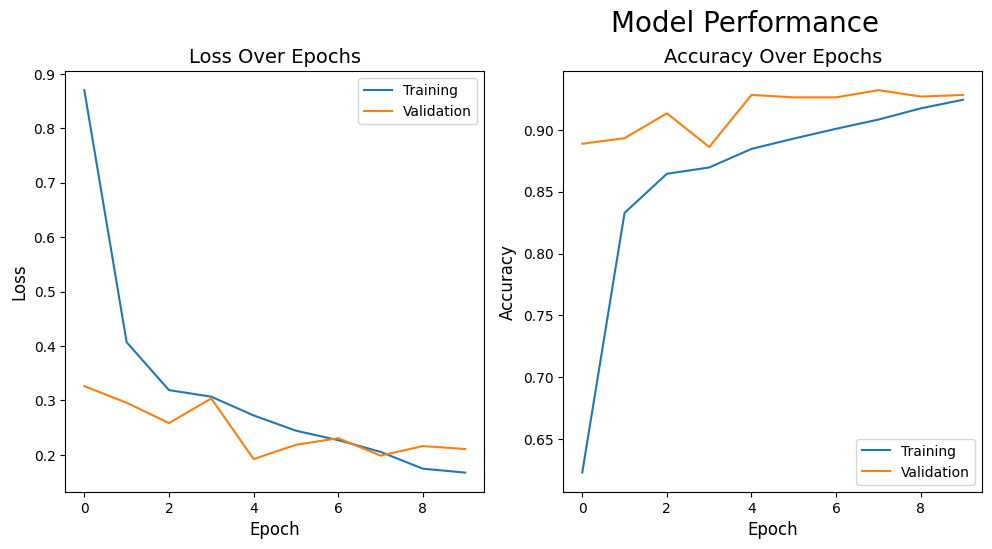

In [35]:
history_dict = history.history
metrics_to_plot = {
    'Loss': ('loss', 'val_loss'),
    'Accuracy': ('accuracy', 'val_accuracy'),
}

plt.figure(figsize=(15, 10))

for i, (metric_name, (train_metric, val_metric)) in enumerate(metrics_to_plot.items(), 1):
    plt.subplot(2, 3, i)
    plt.plot(history_dict[train_metric], label='Training')
    plt.plot(history_dict[val_metric], label='Validation')
    plt.title(f'{metric_name} Over Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.legend()

plt.suptitle('Model Performance',size=20)
plt.tight_layout()
plt.show()

In [36]:
from tensorflow.keras.models import load_model

model = load_model('/content/best_model.keras')


In [37]:
val_set_final = validation_datagen.flow_from_directory(
    '/content/chest-1/valid',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1546 images belonging to 5 classes.


In [38]:
num_steps = len(val_set_final)
predictions_val = model.predict(val_set_final, steps=num_steps, verbose=1)


49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 234ms/step


In [39]:
val_loss, val_acc = model.evaluate(val_set_final)


49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 240ms/step - accuracy: 0.9369 - loss: 0.1732


In [40]:
true_labels = val_set_final.classes
predicted_labels = np.argmax(predictions_val, axis=1)
predicted_labels

array([0, 0, 0, ..., 4, 4, 4])

In [41]:
conf_mat = confusion_matrix(y_true=true_labels, y_pred=predicted_labels)
conf_mat = pd.DataFrame(conf_mat, index=validation_generator.class_indices.keys(), columns=validation_generator.class_indices.keys())

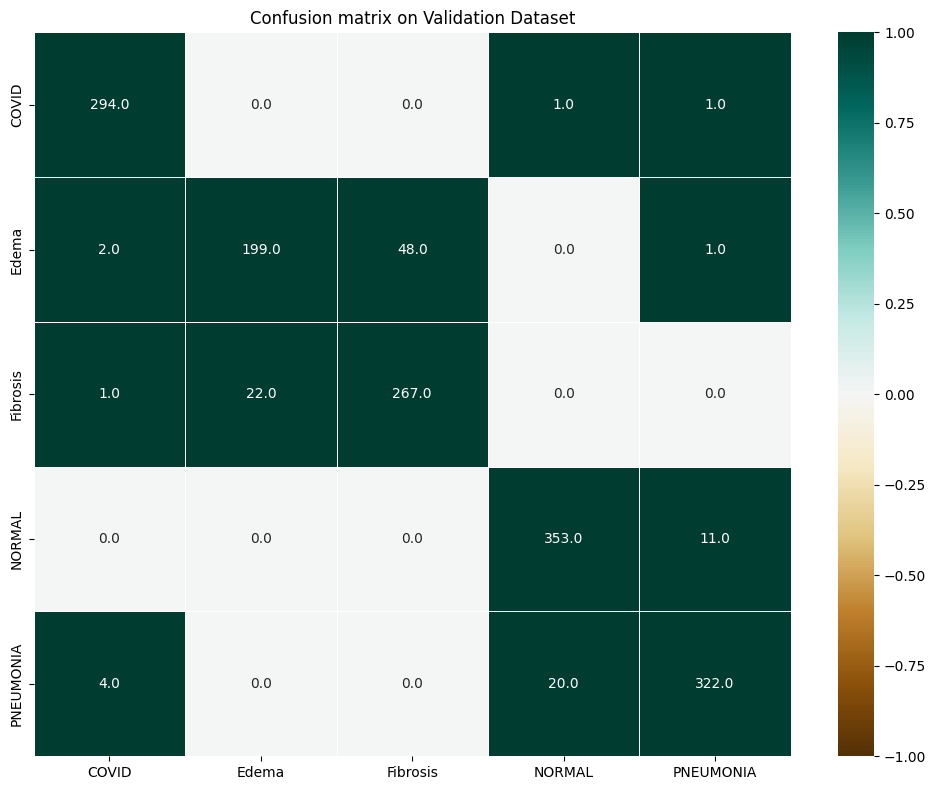

In [42]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat,ax=ax ,cmap='BrBG',center=0,vmin=-1,vmax=1,annot=True,fmt='.1f',linewidth=.5)
ax.set_title('Confusion matrix on Validation Dataset')
plt.tight_layout()
plt.show()

In [43]:
test_set_final = test_datagen.flow_from_directory(
    '/content/chest-1/test',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 763 images belonging to 5 classes.


24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 895ms/step - accuracy: 0.9266 - loss: 0.1969
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step


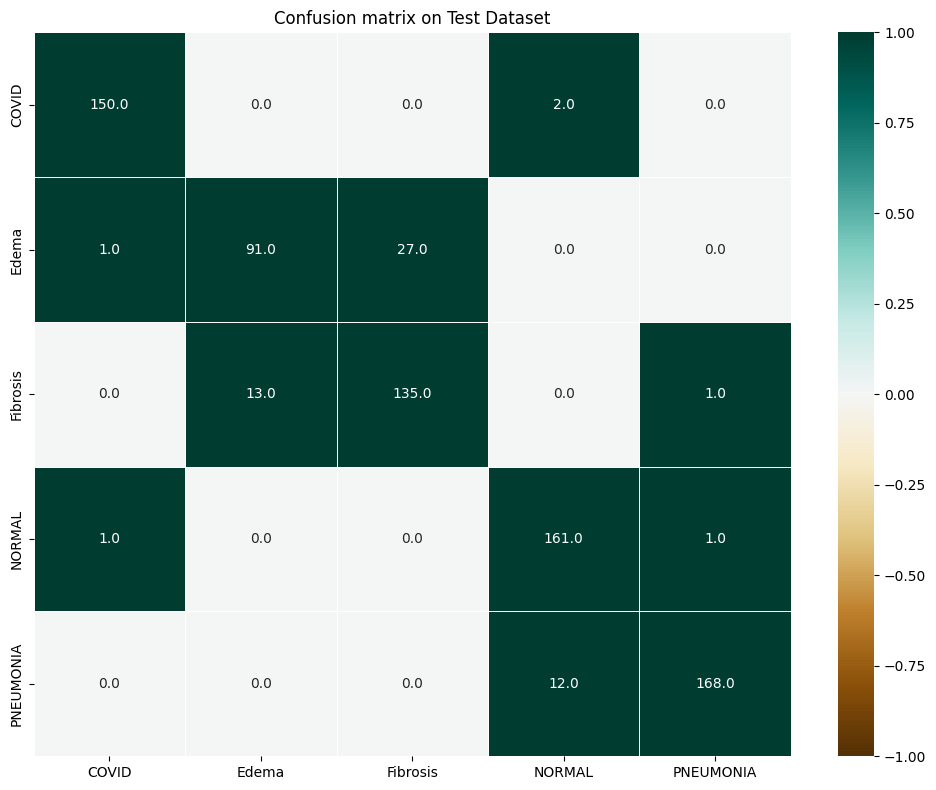

In [44]:
test_loss = model.evaluate(test_set_final)

predictions_test = model.predict(test_set_final)

true_labels = test_set_final.classes
predicted_labels = np.argmax(predictions_test, axis=1)
test_f1 = f1_score(true_labels, predicted_labels, average='weighted')

conf_mat = confusion_matrix(true_labels, predicted_labels)
conf_mat = pd.DataFrame(conf_mat, index=test_set_final.class_indices.keys(), columns=test_set_final.class_indices.keys())

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_mat, ax=ax, cmap='BrBG', center=0, vmin=-1, vmax=1, annot=True, fmt='.1f', linewidth=.5)
ax.set_title('Confusion matrix on Test Dataset')
plt.tight_layout()
plt.show()